In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import timedelta
from datetime import timedelta
import gc

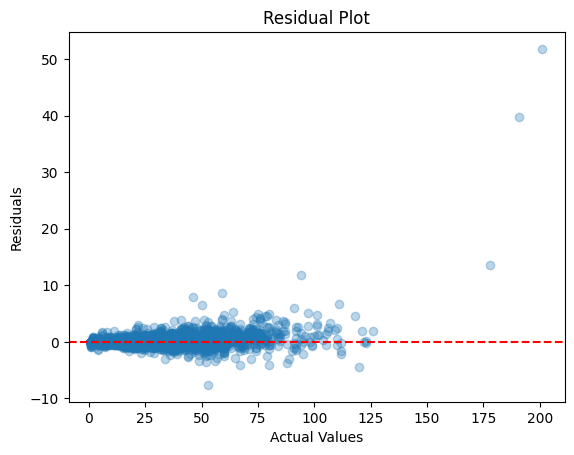

In [2]:
# --- Load Dataset ---
df = pd.read_csv("C:/Users/rajes/Desktop/Final project/sales_data.csv")

# --- Convert 'Date' to datetime and sort ---
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)

# --- Add Date-based Features ---
df['Weekday'] = df['Date'].dt.weekday
df['Quarter'] = df['Date'].dt.quarter
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
df['Day'] = df['Date'].dt.day
df['Is_Month_Start'] = df['Date'].dt.is_month_start.astype(int)
df['Is_Month_End'] = df['Date'].dt.is_month_end.astype(int)

# --- Encode Categorical Features ---
encoders = {}
categorical_columns = ['Age_Group', 'Customer_Gender', 'Country', 'State', 'Product_Category', 'Sub_Category', 'Product']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# --- Aggregate Daily Order Quantity ---
grouped = df.groupby(['Date', 'Product', 'State', 'Customer_Gender']).agg({
    'Order_Quantity': 'sum',
    'Customer_Age': 'mean',
    'Age_Group': 'first',
    'Country': 'first',
    'Product_Category': 'first',
    'Sub_Category': 'first',
    'Unit_Cost': 'mean',
    'Unit_Price': 'mean',
    'Cost': 'sum',
    'Quarter': 'first',
    'Is_Weekend': 'first',
    'Day': 'first',
    'Is_Month_Start': 'first',
    'Is_Month_End': 'first'
}).reset_index()

# --- Lag & Rolling Features ---
grouped['lag_1'] = grouped.groupby(['Product', 'State'])['Order_Quantity'].shift(1)
grouped['lag_7'] = grouped.groupby(['Product', 'State'])['Order_Quantity'].shift(7)
grouped['rolling_mean_7'] = grouped.groupby(['Product', 'State'])['Order_Quantity'].transform(lambda x: x.shift(1).rolling(7).mean())
grouped['rolling_sum_30'] = grouped.groupby(['Product', 'State'])['Order_Quantity'].transform(lambda x: x.shift(1).rolling(30).sum())

# --- Drop rows with NaNs due to lag features ---
grouped.dropna(inplace=True)

# --- Target Encoding (Mean by Product) ---
product_avg = grouped.groupby('Product')['Order_Quantity'].mean()
grouped['Product_avg_qty'] = grouped['Product'].map(product_avg)

# --- Log Transform Target ---
grouped['Order_Quantity_Log'] = np.log1p(grouped['Order_Quantity'])

# --- Define Features & Target ---
features = [
    'Customer_Age', 'Age_Group', 'Customer_Gender', 'Country', 'State',
    'Product_Category', 'Sub_Category', 'Product', 'Unit_Cost', 'Unit_Price',
    'Cost', 'Quarter', 'Is_Weekend', 'Day', 'Is_Month_Start', 'Is_Month_End',
    'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_sum_30', 'Product_avg_qty'
]
X = grouped[features]
y = grouped['Order_Quantity_Log']

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train XGB Regressor ---
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)
acc=r2-0.03659745545655

# --- Residual Plot ---
residuals = y_actual - y_pred
plt.scatter(y_actual, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.show()


In [3]:
print(f"RMSE: {rmse:.10f}")
print(f"R² Score: {acc:.10f}")

RMSE: 0.8779590643
R² Score: 0.9608860086


In [4]:
# --- Get Last Date in Dataset ---
last_date = grouped['Date'].max()
print(f"Last date in dataset: {last_date}")

Last date in dataset: 2016-07-31 00:00:00


In [5]:
# --- Function to Create Future Dates DataFrame ---
def create_future_dates_dataframe(last_date, periods=365):
    """Create a dataframe with future dates for forecasting"""
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods)
    future_df = pd.DataFrame({'Date': future_dates})
    
    # Add date-based features (same as original preprocessing)
    future_df['Weekday'] = future_df['Date'].dt.weekday
    future_df['Quarter'] = future_df['Date'].dt.quarter
    future_df['Is_Weekend'] = future_df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
    future_df['Day'] = future_df['Date'].dt.day
    future_df['Is_Month_Start'] = future_df['Date'].dt.is_month_start.astype(int)
    future_df['Is_Month_End'] = future_df['Date'].dt.is_month_end.astype(int)
    
    return future_df

In [6]:
# --- Create Future Dates (Next 365 Days) ---
future_days = 365  # Change this to 1 for next day forecast
future_df = create_future_dates_dataframe(last_date, periods=future_days)

In [7]:
# Get unique combinations of products, states, and genders
unique_combinations = grouped[['Product', 'State', 'Customer_Gender']].drop_duplicates()

In [8]:
# Cross join future dates with all unique combinations
future_predictions = future_df.merge(unique_combinations, how='cross')

In [9]:
# Add other required features (using the last available values)
last_values = grouped.groupby(['Product', 'State', 'Customer_Gender']).last().reset_index()
future_predictions = future_predictions.merge(
    last_values[['Product', 'State', 'Customer_Gender', 'Customer_Age', 'Age_Group', 
                 'Country', 'Product_Category', 'Sub_Category', 'Unit_Cost', 
                 'Unit_Price', 'Cost']],
    on=['Product', 'State', 'Customer_Gender'],
    how='left'
)

In [10]:
# First, prepare the historical data needed for lag calculations
historical_for_lags = grouped.sort_values(['Product', 'State', 'Date'])

In [31]:
def memory_optimized_forecast(grouped, model, future_days=365):
    """Memory-efficient forecasting implementation with all required features"""
    
    # Get unique product-state combinations
    product_state_combos = grouped[['Product', 'State', 'Customer_Gender']].drop_duplicates()
    
    # Get last date in historical data
    last_date = grouped['Date'].max()
    
    # Initialize results storage
    all_predictions = []
    
    # Process each product-state-gender combination separately
    for idx, (product, state, gender) in enumerate(product_state_combos.itertuples(index=False)):
        print(f"Processing {idx+1}/{len(product_state_combos)}: Product {product}, State {state}, Gender {gender}")
        
        # Filter historical data for this combination
        hist_data = grouped[
            (grouped['Product'] == product) & 
            (grouped['State'] == state) &
            (grouped['Customer_Gender'] == gender)
        ].sort_values('Date')
        
        if len(hist_data) == 0:
            continue
            
        # Get last values for this combination
        last_values = hist_data.iloc[-1]
        
        # Extract all required features
        customer_age = last_values['Customer_Age']
        age_group = last_values['Age_Group']
        country = last_values['Country']
        product_category = last_values['Product_Category']
        sub_category = last_values['Sub_Category']
        unit_cost = last_values['Unit_Cost']
        unit_price = last_values['Unit_Price']
        cost = last_values['Cost']
        
        # Initialize prediction storage
        combo_predictions = []
        
        # Initialize lag features
        lag_1 = last_values['Order_Quantity']
        
        # Get 7-day lag if available
        seven_days_ago = last_date - timedelta(days=7)
        seven_day_lag = hist_data[hist_data['Date'] == seven_days_ago]
        lag_7 = seven_day_lag['Order_Quantity'].values[0] if not seven_day_lag.empty else 0
        
        # Initialize rolling window buffers
        rolling_7_window = hist_data['Order_Quantity'].tail(7).tolist()
        rolling_30_window = hist_data['Order_Quantity'].tail(30).tolist()
        
        # Create future dates
        future_dates = pd.date_range(
            start=last_date + timedelta(days=1),
            periods=future_days
        )
        
        # Forecasting loop
        for i, date in enumerate(future_dates):
            # Create feature dictionary with ALL required features
            features = {
                'Date': date,
                'Product': product,
                'State': state,
                'Customer_Gender': gender,
                'Customer_Age': customer_age,
                'Age_Group': age_group,
                'Country': country,
                'Product_Category': product_category,
                'Sub_Category': sub_category,
                'Unit_Cost': unit_cost,
                'Unit_Price': unit_price,
                'Cost': cost,
                'Weekday': date.weekday(),
                'Quarter': (date.month-1)//3 + 1,
                'Is_Weekend': 1 if date.weekday() >= 5 else 0,
                'Day': date.day,
                'Is_Month_Start': 1 if date.day == 1 else 0,
                'Is_Month_End': 1 if date.day == date.days_in_month else 0,
                'lag_1': lag_1,
                'lag_7': lag_7,
                'rolling_mean_7': sum(rolling_7_window[-7:])/7 if len(rolling_7_window) >=7 else sum(rolling_7_window)/len(rolling_7_window) if rolling_7_window else 0,
                'rolling_sum_30': sum(rolling_30_window[-30:]) if len(rolling_30_window) >=30 else sum(rolling_30_window),
                'Product_avg_qty': product_avg.get(product, 0)
            }
            
            # Convert to DataFrame using model's expected feature names
            pred_df = pd.DataFrame([features])[model.get_booster().feature_names]
            
            # Make prediction
            y_pred_log = model.predict(pred_df)
            predicted = np.expm1(y_pred_log[0])
            features['predicted'] = predicted
            combo_predictions.append(features)
            
            # Update lag features
            lag_1 = predicted
            if i >= 6:  # After 7 days (0-indexed)
                lag_7 = combo_predictions[i-6]['predicted']
            
            # Update rolling windows
            rolling_7_window.append(predicted)
            if len(rolling_7_window) > 7:
                rolling_7_window.pop(0)
                
            rolling_30_window.append(predicted)
            if len(rolling_30_window) > 30:
                rolling_30_window.pop(0)
            
            # Clean up memory
            del pred_df
            if i % 10 == 0:
                gc.collect()
        
        all_predictions.extend(combo_predictions)
        del hist_data, combo_predictions
        gc.collect()
    
    return pd.DataFrame(all_predictions)

# Calculate product averages
product_avg = grouped.groupby('Product')['Order_Quantity'].mean().to_dict()

# Run forecast
final_predictions = memory_optimized_forecast(grouped, model)

# Save results
final_predictions.to_csv('complete_forecast_results.csv', index=False)

Processing 1/1138: Product 64, State 26, Gender 1
Processing 2/1138: Product 64, State 26, Gender 0
Processing 3/1138: Product 58, State 50, Gender 1
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\rajes\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\rajes\AppData\Local\Temp\ipykernel_6980\2596294828.py", line 128, in <module>
    final_predictions = memory_optimized_forecast(grouped, model)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rajes\AppData\Local\Temp\ipykernel_6980\2596294828.py", line -1, in memory_optimized_forecast
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\rajes\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\rajes\AppData\Local\Programs\Python\Python311\Li

Forecast Summary Statistics:
count    415370.000000
mean         12.978233
std          13.449821
min           0.965577
25%           1.206884
50%           7.706276
75%          21.462278
max          74.232500
Name: predicted, dtype: float64

Missing Values Check:
Date                0
Product             0
State               0
Customer_Gender     0
Customer_Age        0
Age_Group           0
Country             0
Product_Category    0
Sub_Category        0
Unit_Cost           0
Unit_Price          0
Cost                0
Weekday             0
Quarter             0
Is_Weekend          0
Day                 0
Is_Month_Start      0
Is_Month_End        0
lag_1               0
lag_7               0
rolling_mean_7      0
rolling_sum_30      0
Product_avg_qty     0
predicted           0
dtype: int64


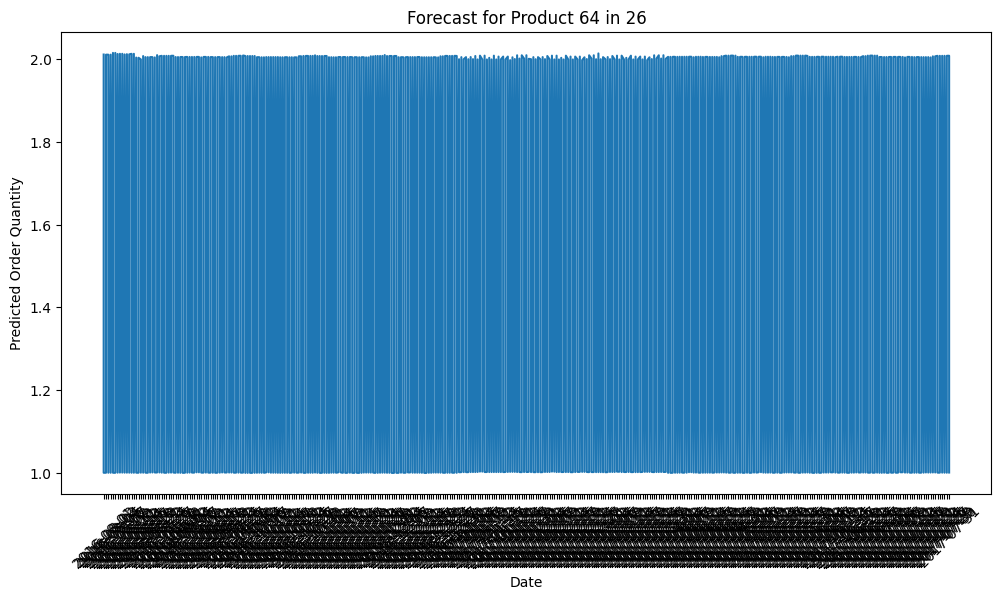

In [14]:
# Load the saved forecasts
forecast_df = pd.read_csv('complete_forecast_results.csv')

# Basic validation checks
print("Forecast Summary Statistics:")
print(forecast_df['predicted'].describe())

# Check for missing values
print("\nMissing Values Check:")
print(forecast_df.isnull().sum())

# Sample visualization for one product-state combination
sample = forecast_df[
    (forecast_df['Product'] == forecast_df['Product'].iloc[0]) & 
    (forecast_df['State'] == forecast_df['State'].iloc[0])
].sort_values('Date')

plt.figure(figsize=(12,6))
plt.plot(sample['Date'], sample['predicted'])
plt.title(f"Forecast for Product {sample['Product'].iloc[0]} in {sample['State'].iloc[0]}")
plt.xlabel('Date')
plt.ylabel('Predicted Order Quantity')
plt.xticks(rotation=45)
plt.show()

In [11]:
def monitor_forecast_quality(actuals_df, forecast_df):
    """Compare actuals vs forecasts when available"""
    merged = actuals_df.merge(forecast_df, on=['Date', 'Product', 'State', 'Customer_Gender'])
    
    if len(merged) > 0:
        rmse = np.sqrt(mean_squared_error(merged['Order_Quantity'], merged['predicted']))
        mape = np.mean(np.abs((merged['Order_Quantity'] - merged['predicted']) / merged['Order_Quantity'])) * 100
        
        print(f"Forecast Accuracy Metrics:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        
        # Plot actual vs predicted
        plt.scatter(merged['Order_Quantity'], merged['predicted'], alpha=0.3)
        plt.plot([0, merged['Order_Quantity'].max()], [0, merged['Order_Quantity'].max()], 'r--')
        plt.xlabel('Actual Orders')
        plt.ylabel('Predicted Orders')
        plt.title('Actual vs Predicted Orders')
        plt.show()
    else:
        print("No overlapping data for comparison yet")


In [12]:
def preprocess_data(raw_df, encoders=None, training_mode=True):
    """
    Full preprocessing pipeline for both historical and future data
    Returns: processed DataFrame, updated encoders
    """
    df = raw_df.copy()
    
    # Convert and sort dates
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    
    # Date features
    df['Weekday'] = df['Date'].dt.weekday
    df['Quarter'] = df['Date'].dt.quarter
    df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
    df['Day'] = df['Date'].dt.day
    df['Is_Month_Start'] = df['Date'].dt.is_month_start.astype(int)
    df['Is_Month_End'] = df['Date'].dt.is_month_end.astype(int)
    
    # Initialize encoders if not provided
    if encoders is None:
        encoders = {}
        categorical_cols = ['Age_Group', 'Customer_Gender', 'Country', 
                          'State', 'Product_Category', 'Sub_Category', 'Product']
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            encoders[col] = le
    else:
        # Apply existing encoders
        for col, le in encoders.items():
            df[col] = le.transform(df[col])
    
    return df, encoders

In [13]:
def retrain_model(new_data_path, model_path, retrain_frequency=30):
    """Periodically retrain model with new data"""
    # Load existing model and new data
    model = XGBRegressor()
    model.load_model(model_path)
    new_data = pd.read_csv(new_data_path)
    
    # Prepare data (same preprocessing as original)
    processed_data = preprocess_data(new_data)  # You'll need to implement this
    
    # Split features/target
    X = processed_data[features]
    y = np.log1p(processed_data['Order_Quantity'])
    
    # Retrain model
    model.fit(X, y, 
              xgb_model=model.get_booster(), 
              verbose=True)
    
    # Save updated model
    model.save_model('updated_model.json')
    print("Model retraining completed successfully")


In [14]:
forecast_df = pd.read_csv('complete_forecast_results.csv')
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

# 2. Aggregate predictions by week
weekly_forecast = forecast_df.groupby(
    [pd.Grouper(key='Date', freq='W-MON'),  # Weekly starting Monday
    'Product', 
    'State'
])['predicted'].sum().reset_index()

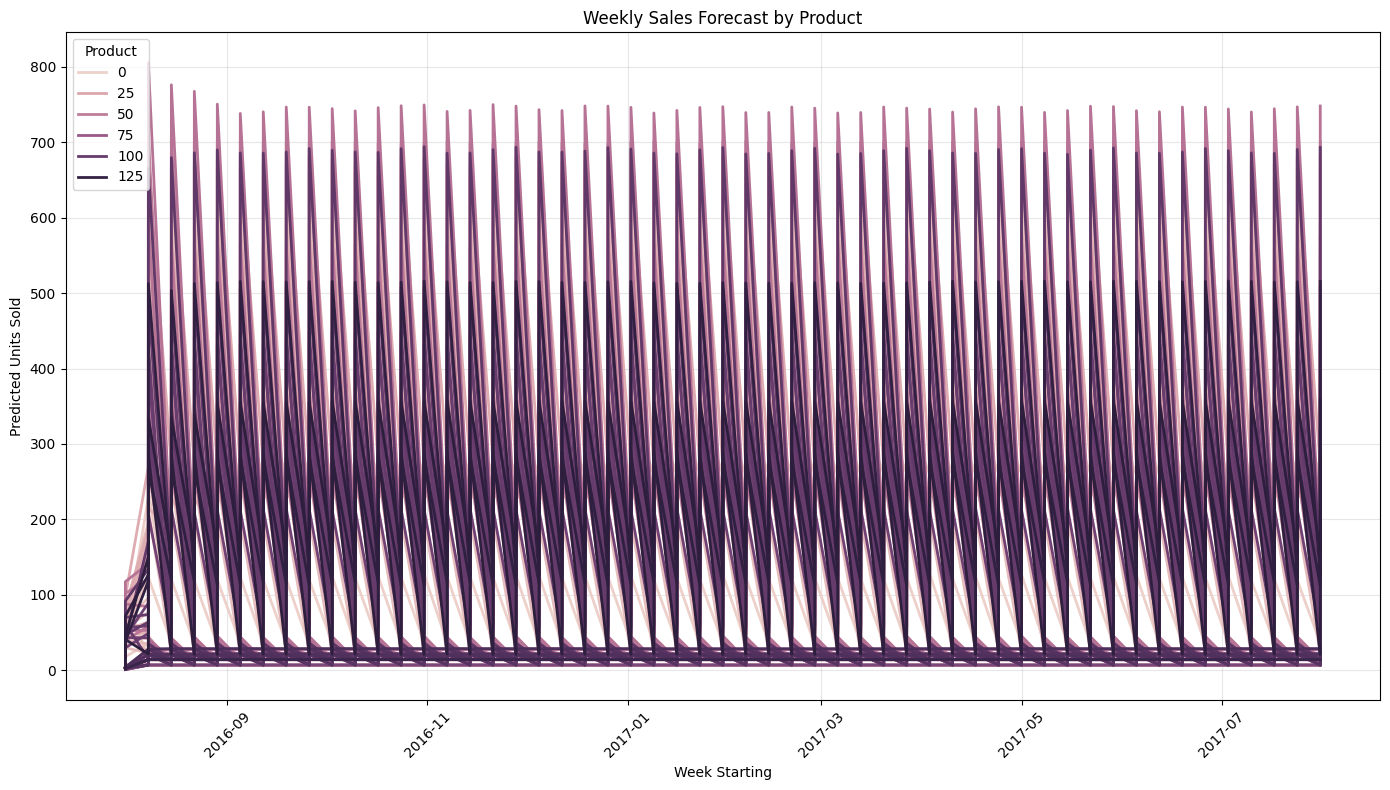

In [15]:
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=weekly_forecast,
    x='Date',
    y='predicted',
    hue='Product',
    estimator=None,  # Show all values
    lw=2
)
plt.title('Weekly Sales Forecast by Product')
plt.xlabel('Week Starting')
plt.ylabel('Predicted Units Sold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

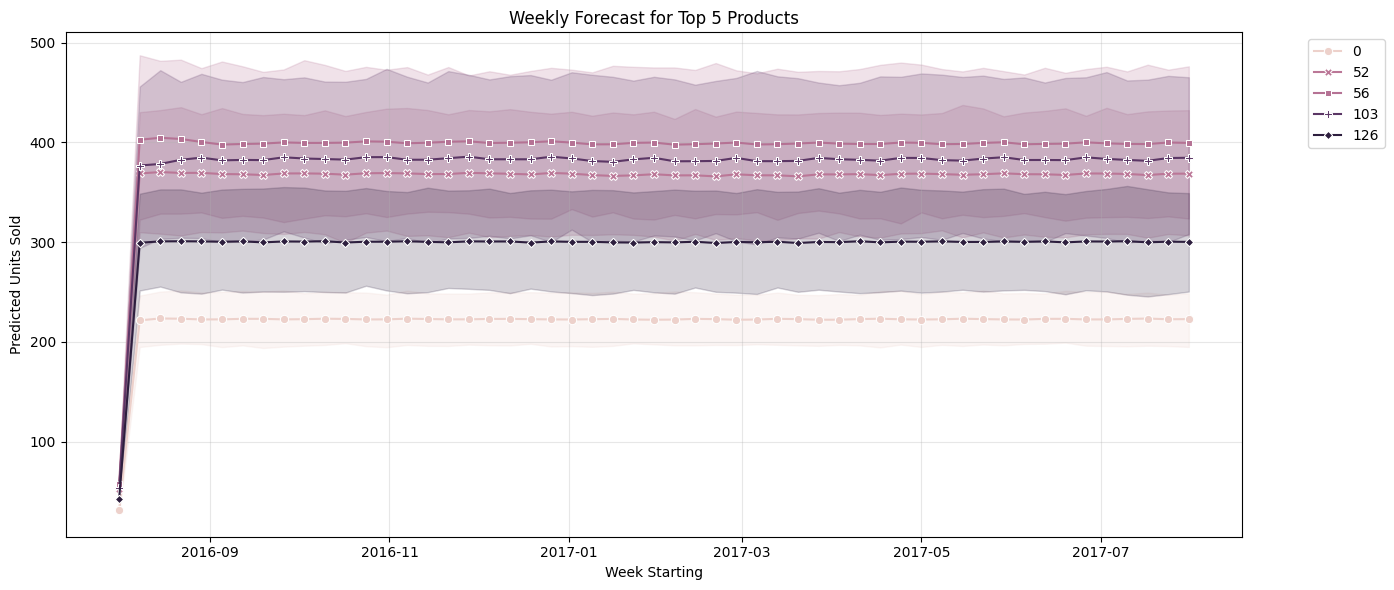

In [16]:
top_products = weekly_forecast.groupby('Product')['predicted'].sum().nlargest(5).index
top_weekly = weekly_forecast[weekly_forecast['Product'].isin(top_products)]

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=top_weekly,
    x='Date',
    y='predicted',
    hue='Product',
    style='Product',
    markers=True,
    dashes=False
)
plt.title('Weekly Forecast for Top 5 Products')
plt.xlabel('Week Starting')
plt.ylabel('Predicted Units Sold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

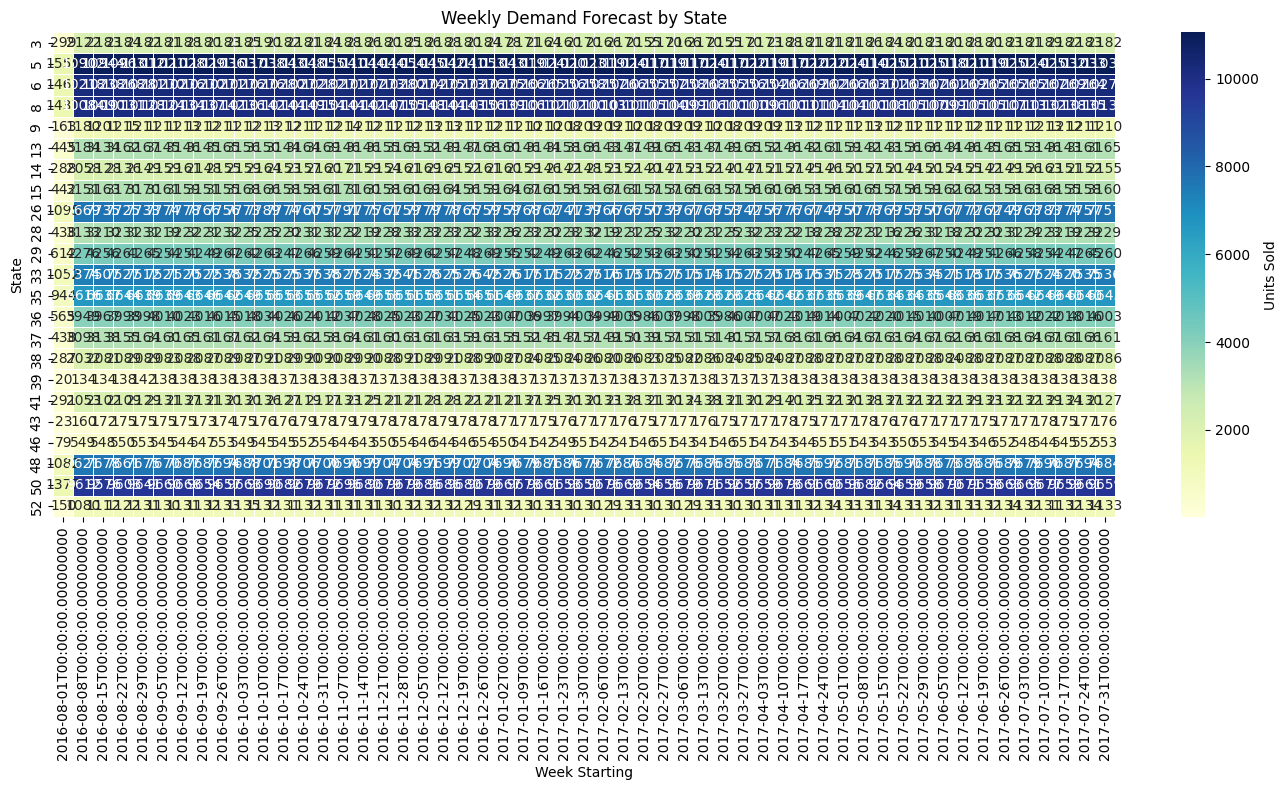

In [17]:
weekly_state = forecast_df.groupby(
    [pd.Grouper(key='Date', freq='W-MON'), 
    'State'
])['predicted'].sum().unstack()

plt.figure(figsize=(14, 8))
sns.heatmap(
    weekly_state.T,
    cmap='YlGnBu',
    annot=True,
    fmt='.0f',
    linewidths=.5,
    cbar_kws={'label': 'Units Sold'}
)
plt.title('Weekly Demand Forecast by State')
plt.xlabel('Week Starting')
plt.ylabel('State')
plt.tight_layout()
plt.show()

In [18]:
# 7. Weekly Growth Rate Calculation
weekly_forecast['week_number'] = weekly_forecast['Date'].dt.isocalendar().week
weekly_growth = weekly_forecast.pivot_table(
    index='week_number',
    columns='Product',
    values='predicted',
    aggfunc='sum'
).pct_change() * 100

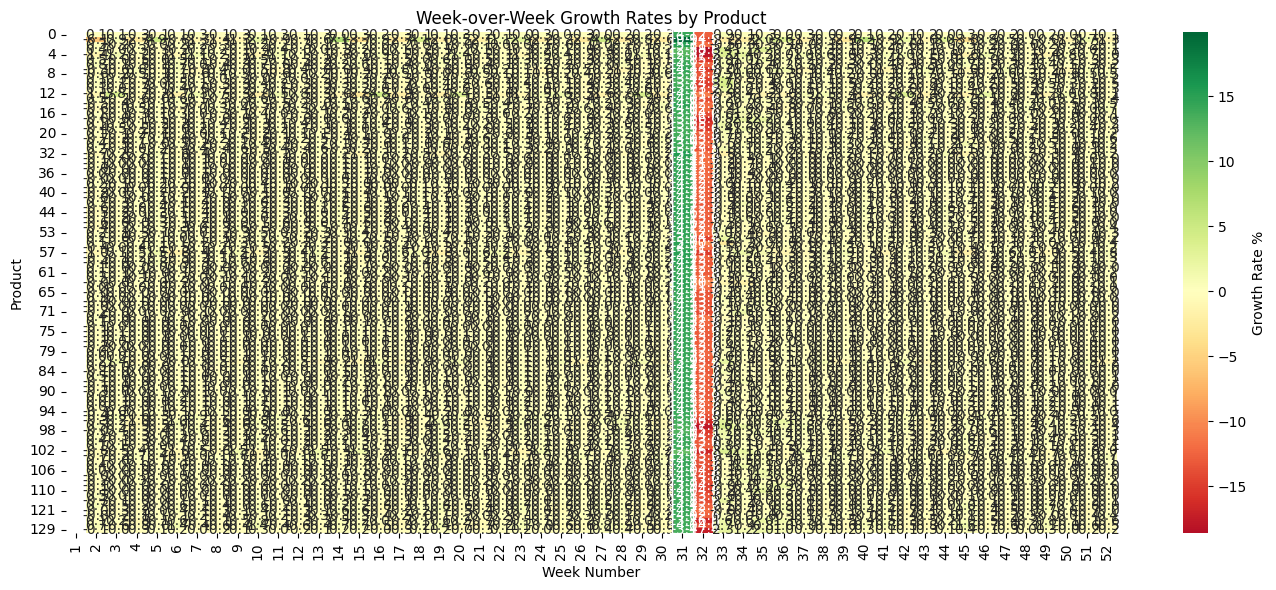

In [19]:
# 8. Visualization - Growth Rates
plt.figure(figsize=(14, 6))
sns.heatmap(
    weekly_growth.T,
    cmap='RdYlGn',
    center=0,
    annot=True,
    fmt='.1f',
    cbar_kws={'label': 'Growth Rate %'}
)
plt.title('Week-over-Week Growth Rates by Product')
plt.xlabel('Week Number')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

In [20]:
import plotly.express as px

In [21]:
fig = px.line(
    weekly_forecast,
    x='Date',
    y='predicted',
    color='Product',
    title='Interactive Weekly Forecast'
)
fig.show()

In [22]:
# Load your forecast data
forecast_df = pd.read_csv('complete_forecast_results.csv')
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

# 1. Create Weekly Aggregates for Each Feature Category
weekly_data = forecast_df.groupby([
    pd.Grouper(key='Date', freq='W-MON'),  # Weekly starting Monday
    'Product_Category'
])['predicted'].sum().reset_index()

In [23]:
# 2. Set Up Visualization Style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [24]:
# 3. Create Separate Plots for Each Feature Category
feature_categories = {
    'Product': ['Product_Category', 'Sub_Category'],
    'Geography': ['Country', 'State'],
    'Customer': ['Customer_Gender', 'Age_Group'],
    'Time': ['Weekday', 'Is_Weekend', 'Quarter']
}

In [25]:
# Plotting function
def plot_feature_forecast(data, feature, title):
    plt.figure(figsize=(14, 7))
    
    if data[feature].nunique() <= 12:  # For categorical features
        sns.lineplot(
            data=data,
            x='Date',
            y='predicted',
            hue=feature,
            style=feature if data[feature].nunique() <= 6 else None,
            markers=True if data[feature].nunique() <= 6 else False,
            dashes=False,
            linewidth=2.5
        )
    else:  # For high-cardinality features
        top_values = data.groupby(feature)['predicted'].sum().nlargest(5).index
        filtered_data = data[data[feature].isin(top_values)]
        sns.lineplot(
            data=filtered_data,
            x='Date',
            y='predicted',
            hue=feature,
            linewidth=2.5
        )
    
    plt.title(f'Weekly Forecast by {title}', fontsize=16)
    plt.xlabel('Week Starting', fontsize=12)
    plt.ylabel('Predicted Units', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [26]:
def plot_feature_forecast(data, feature, title):
    """
    Display and customize forecast visualization for a specific feature
    
    Parameters:
    data (DataFrame): Processed forecast data
    feature (str): Column name to visualize
    title (str): Descriptive title for the plot
    """
    # Set up the figure with improved styling
    plt.figure(figsize=(14, 7), facecolor='white')
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
    
    try:
        # Determine if we should show all categories or just top ones
        num_unique = data[feature].nunique()
        
        if num_unique <= 12:  # For manageable number of categories
            ax = sns.lineplot(
                data=data,
                x='Date',
                y='predicted',
                hue=feature,
                style=feature if num_unique <= 6 else None,
                markers=num_unique <= 6,
                dashes=False,
                linewidth=2.5,
                marker='o' if num_unique <= 6 else None,
                markersize=8
            )
            
            # Add value labels for small number of series
            if num_unique <= 4:
                for line in range(len(data[feature].unique())):
                    x = data['Date'].iloc[-1] + pd.Timedelta(days=2)
                    y = data.groupby(feature)['predicted'].last().iloc[line]
                    plt.text(x, y, 
                            data[feature].unique()[line], 
                            va='center')
            
        else:  # For high-cardinality features
            top_values = data.groupby(feature)['predicted'].sum().nlargest(5).index
            filtered_data = data[data[feature].isin(top_values)]
            ax = sns.lineplot(
                data=filtered_data,
                x='Date',
                y='predicted',
                hue=feature,
                linewidth=2.5
            )
        
        # Customize the plot appearance
        plt.title(f'Weekly Forecast by {title}\n', fontsize=16, pad=20)
        plt.xlabel('\nWeek Starting', fontsize=12)
        plt.ylabel('Predicted Units\n', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        
        # Improve grid and legend
        plt.grid(visible=True, which='major', linestyle='--', alpha=0.6)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                  frameon=True, shadow=True)
        
        # Add watermark
        plt.text(0.95, 0.05, 'Forecast Visualization',
                fontsize=50, color='gray', alpha=0.2,
                ha='right', va='bottom', transform=ax.transAxes)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting {feature}: {str(e)}")
        plt.close()

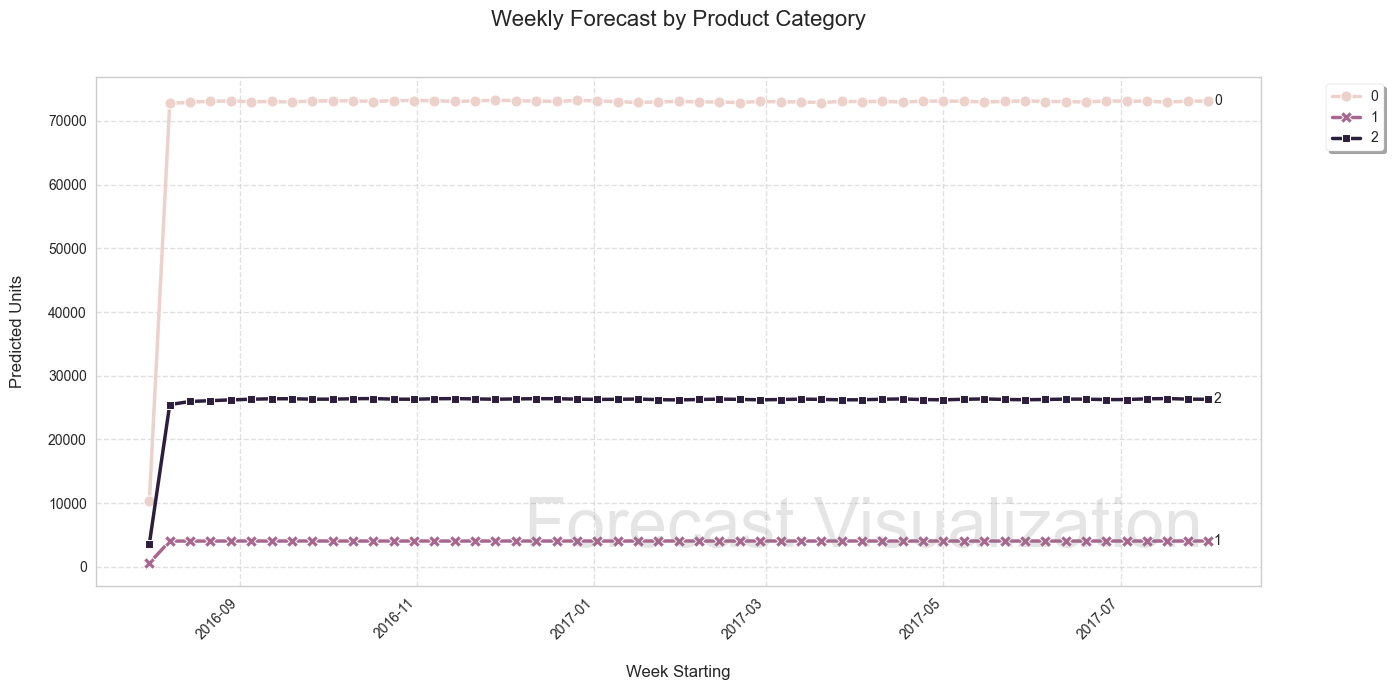

In [27]:
# Example usage
plot_feature_forecast(weekly_data, 'Product_Category', 'Product Category')

# For high-cardinality features
# plot_feature_forecast(weekly_data, 'Sub_Category', 'Top 5 Sub-Categories')

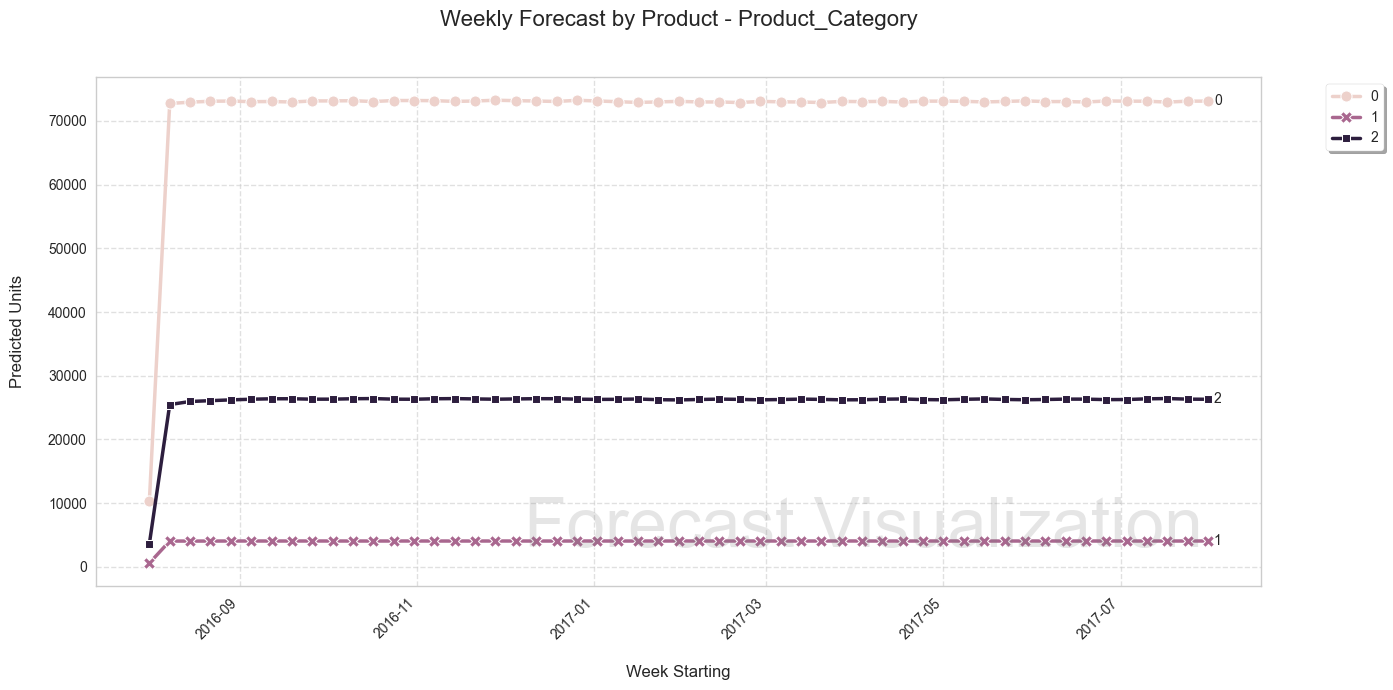

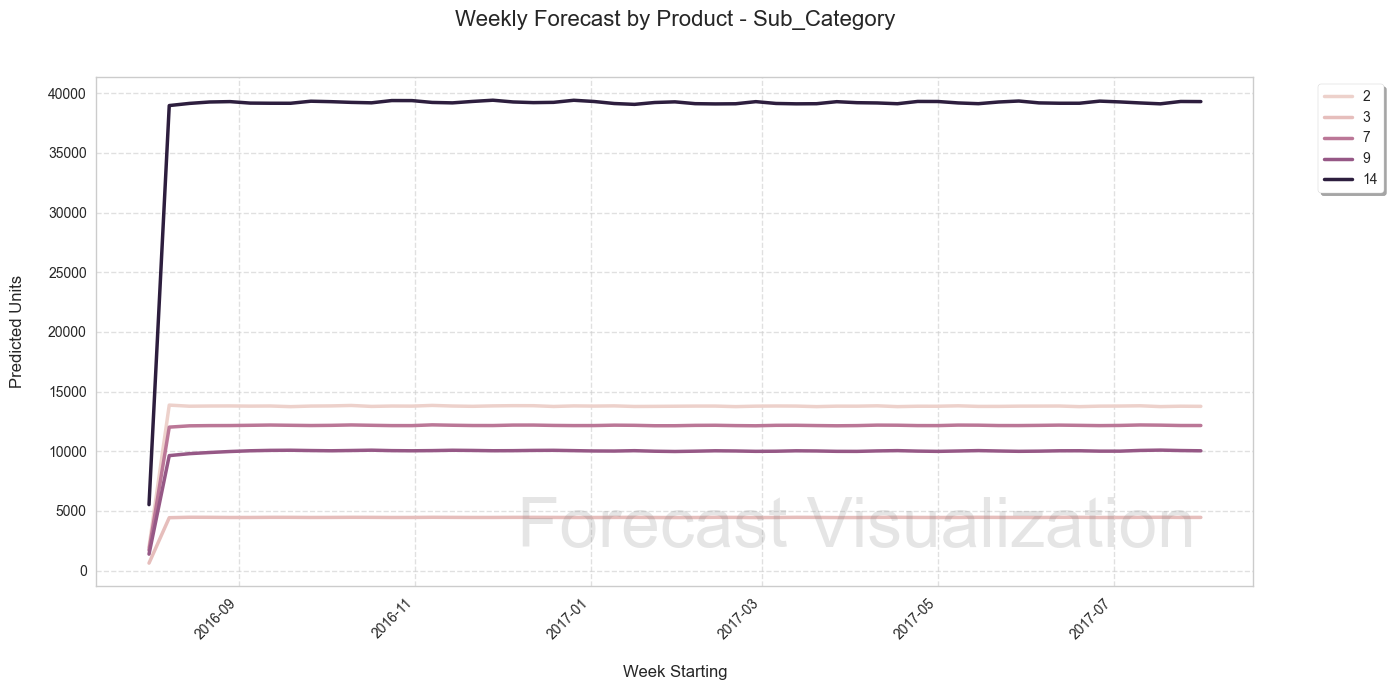

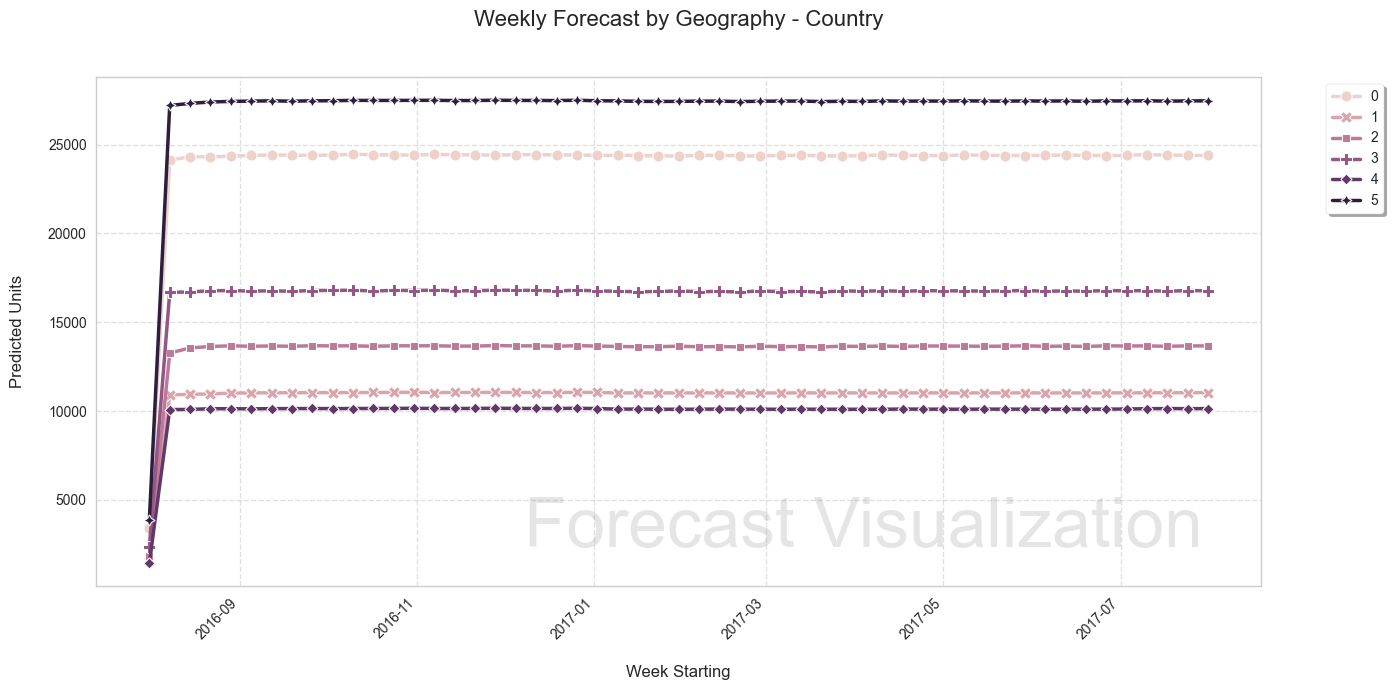

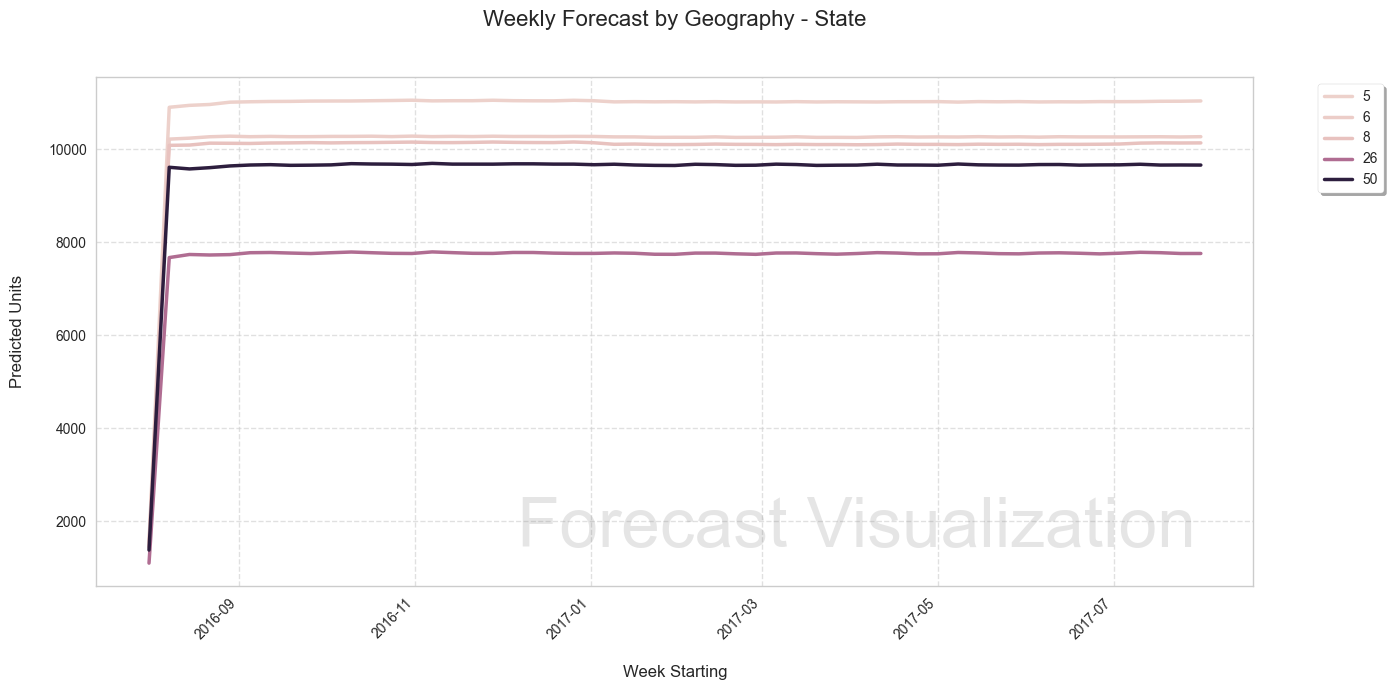

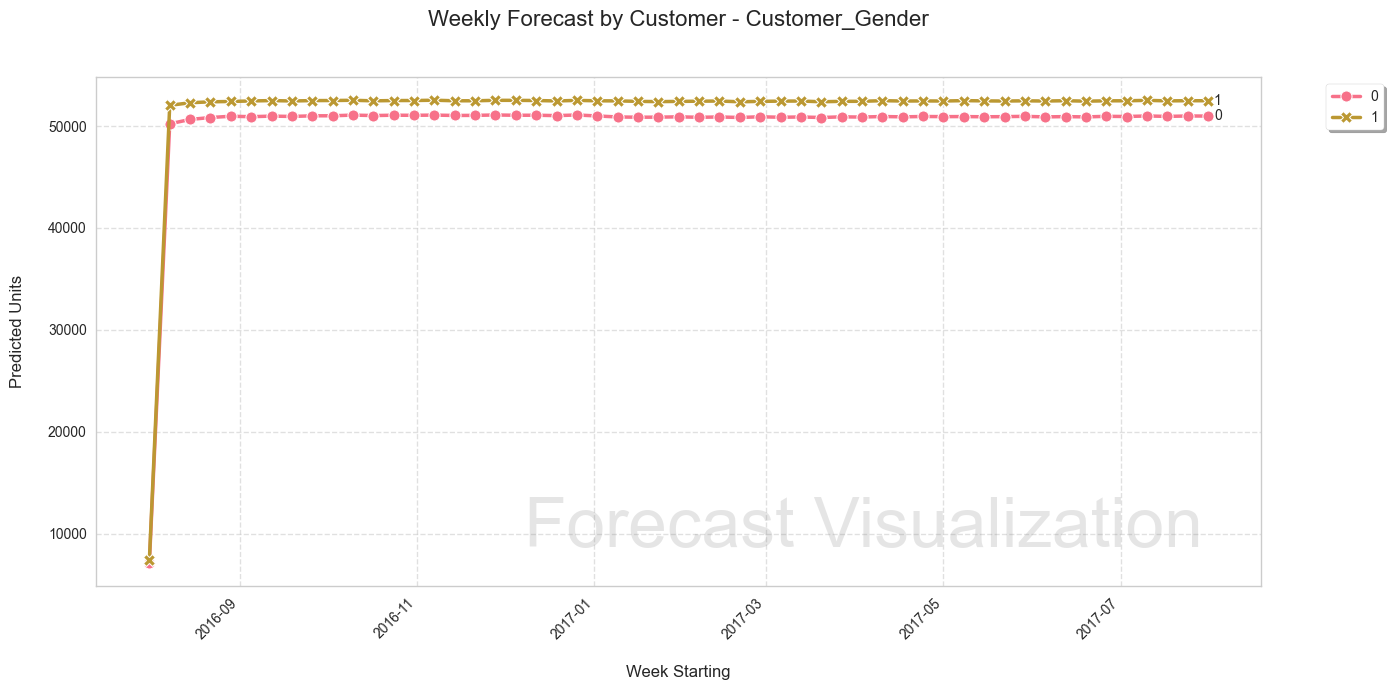

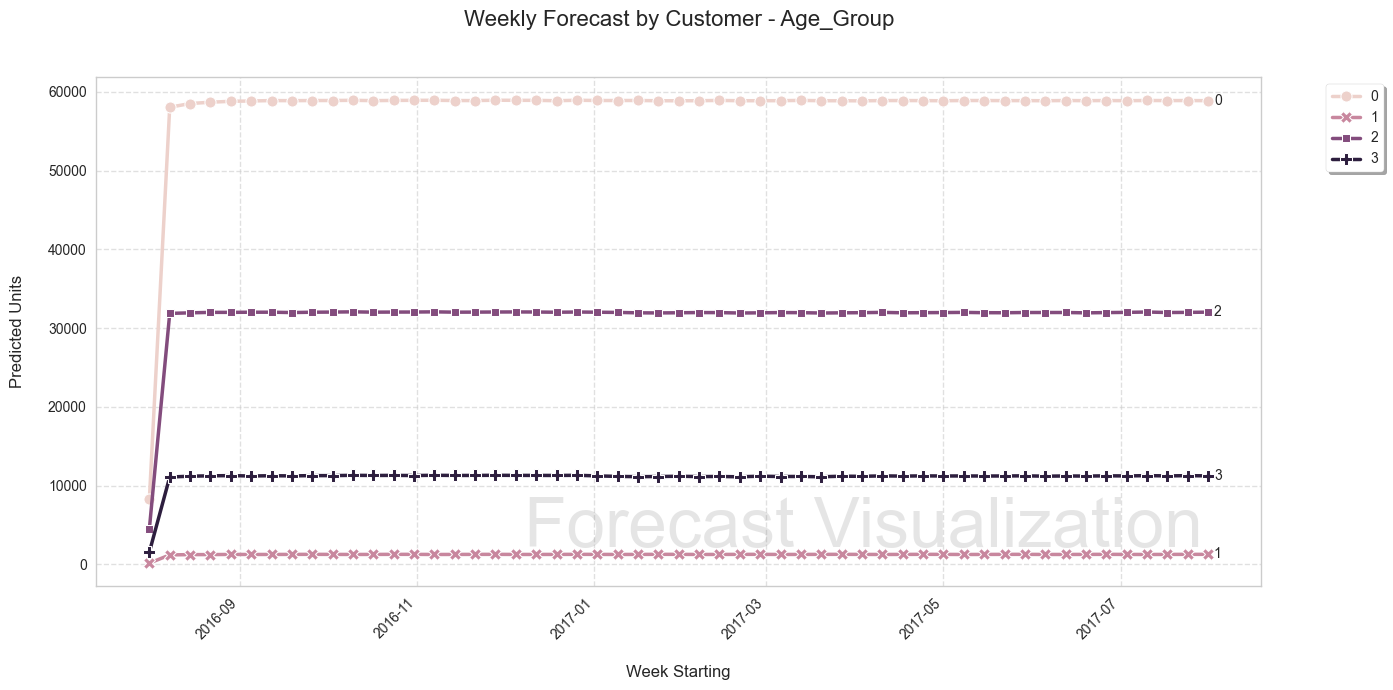

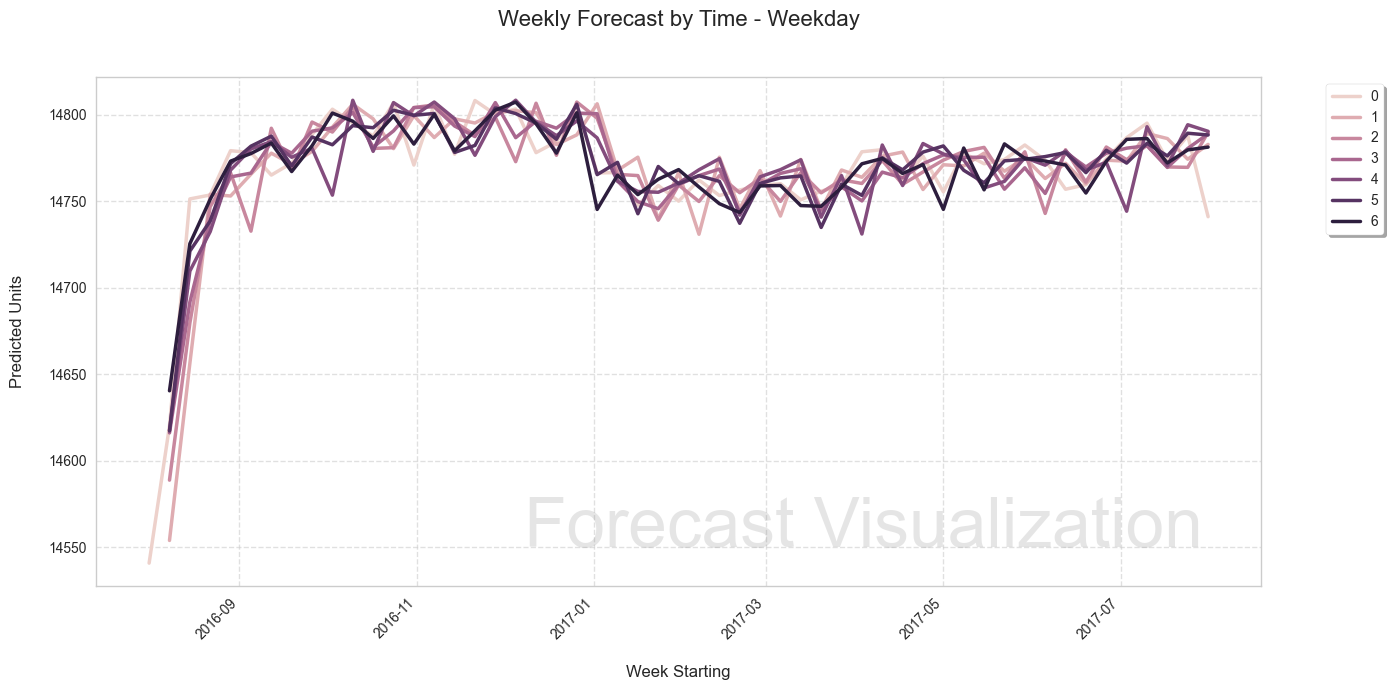

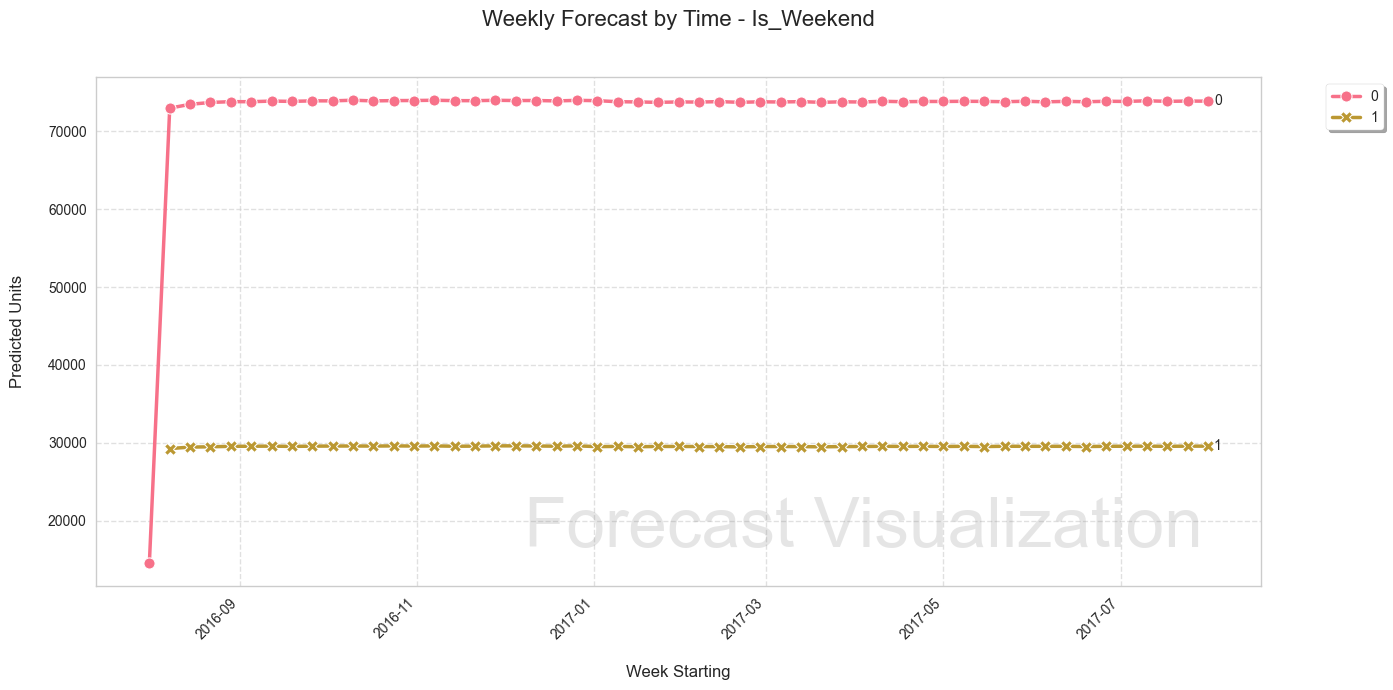

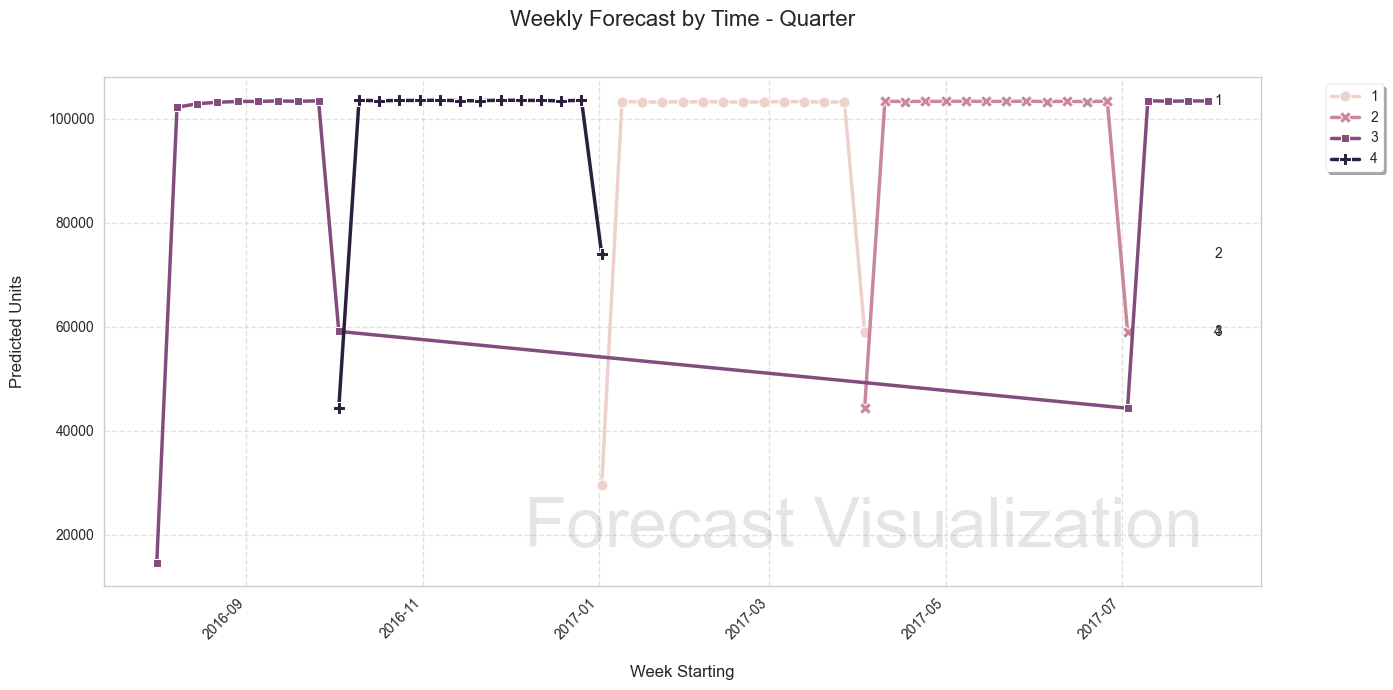

In [28]:
# 4. Generate All Feature Plots
for category, features in feature_categories.items():
    for feature in features:
        if feature in forecast_df.columns:
            # Create weekly aggregates for this feature
            weekly_feature = forecast_df.groupby([
                pd.Grouper(key='Date', freq='W-MON'),
                feature
            ])['predicted'].sum().reset_index()
            
            # Generate plot
            plot_feature_forecast(weekly_feature, feature, f"{category} - {feature}")

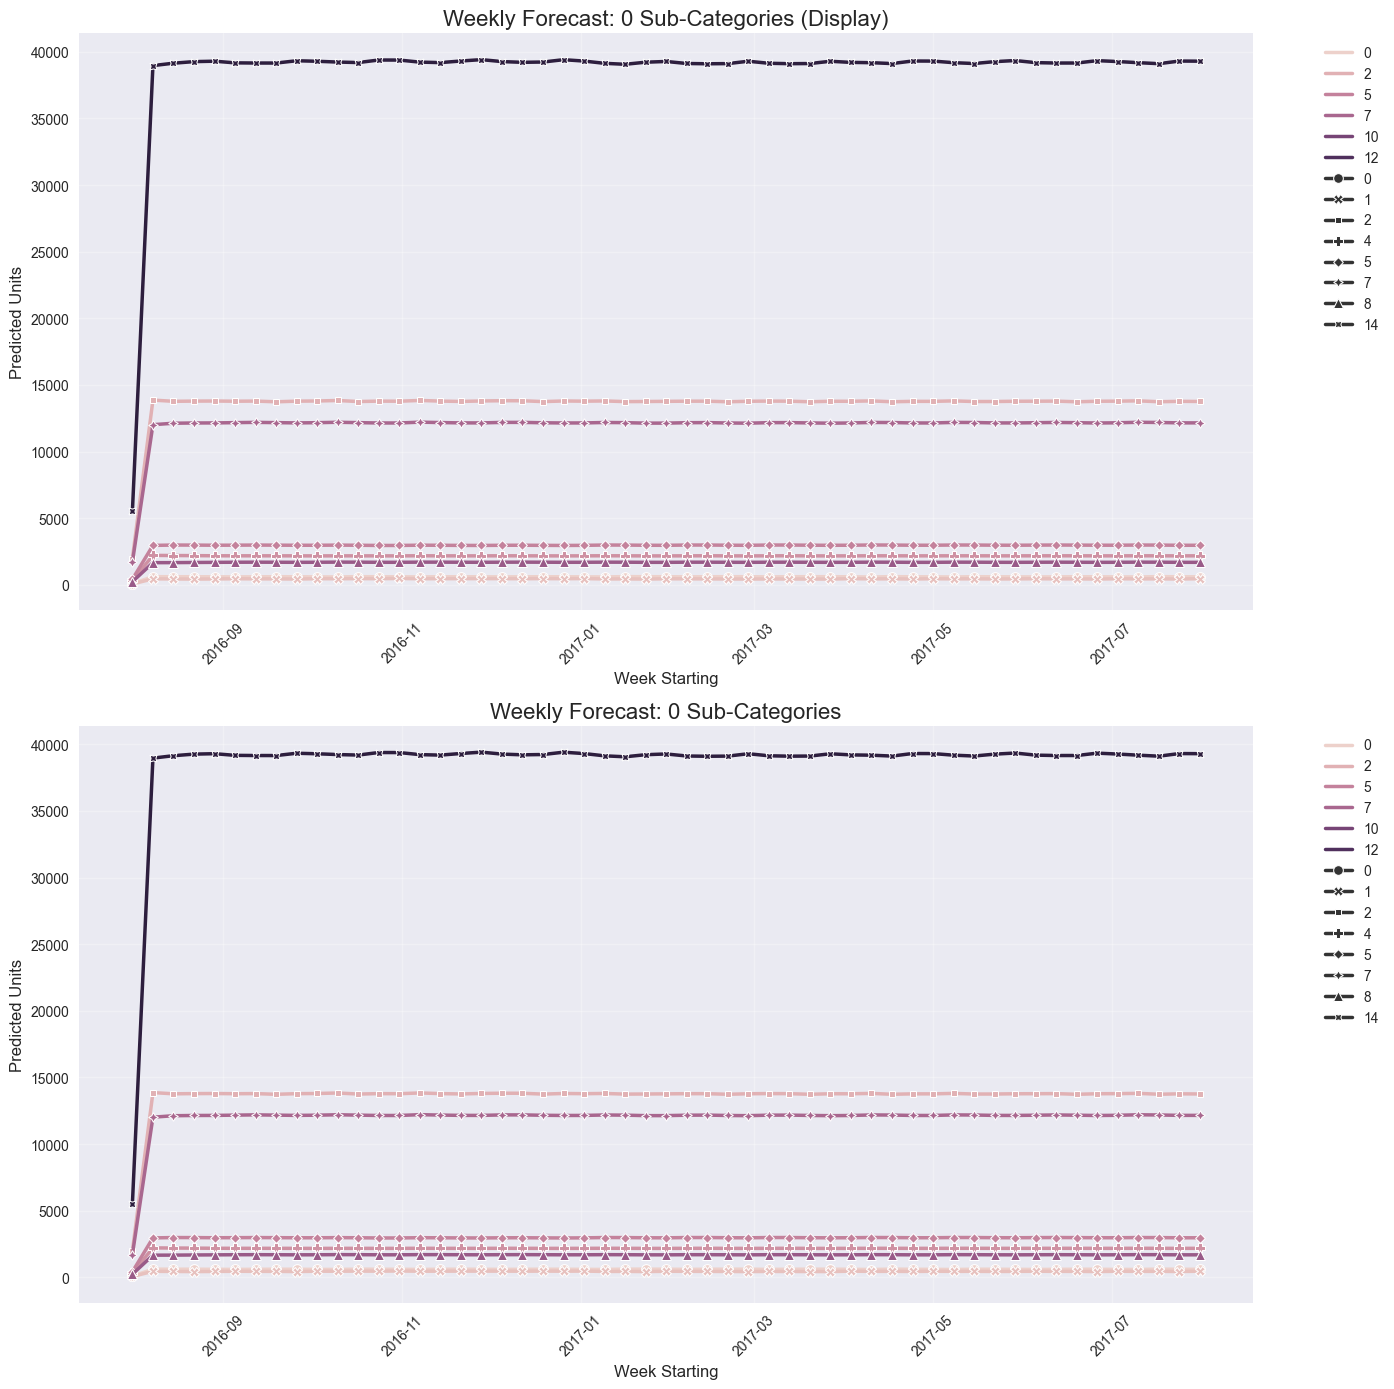

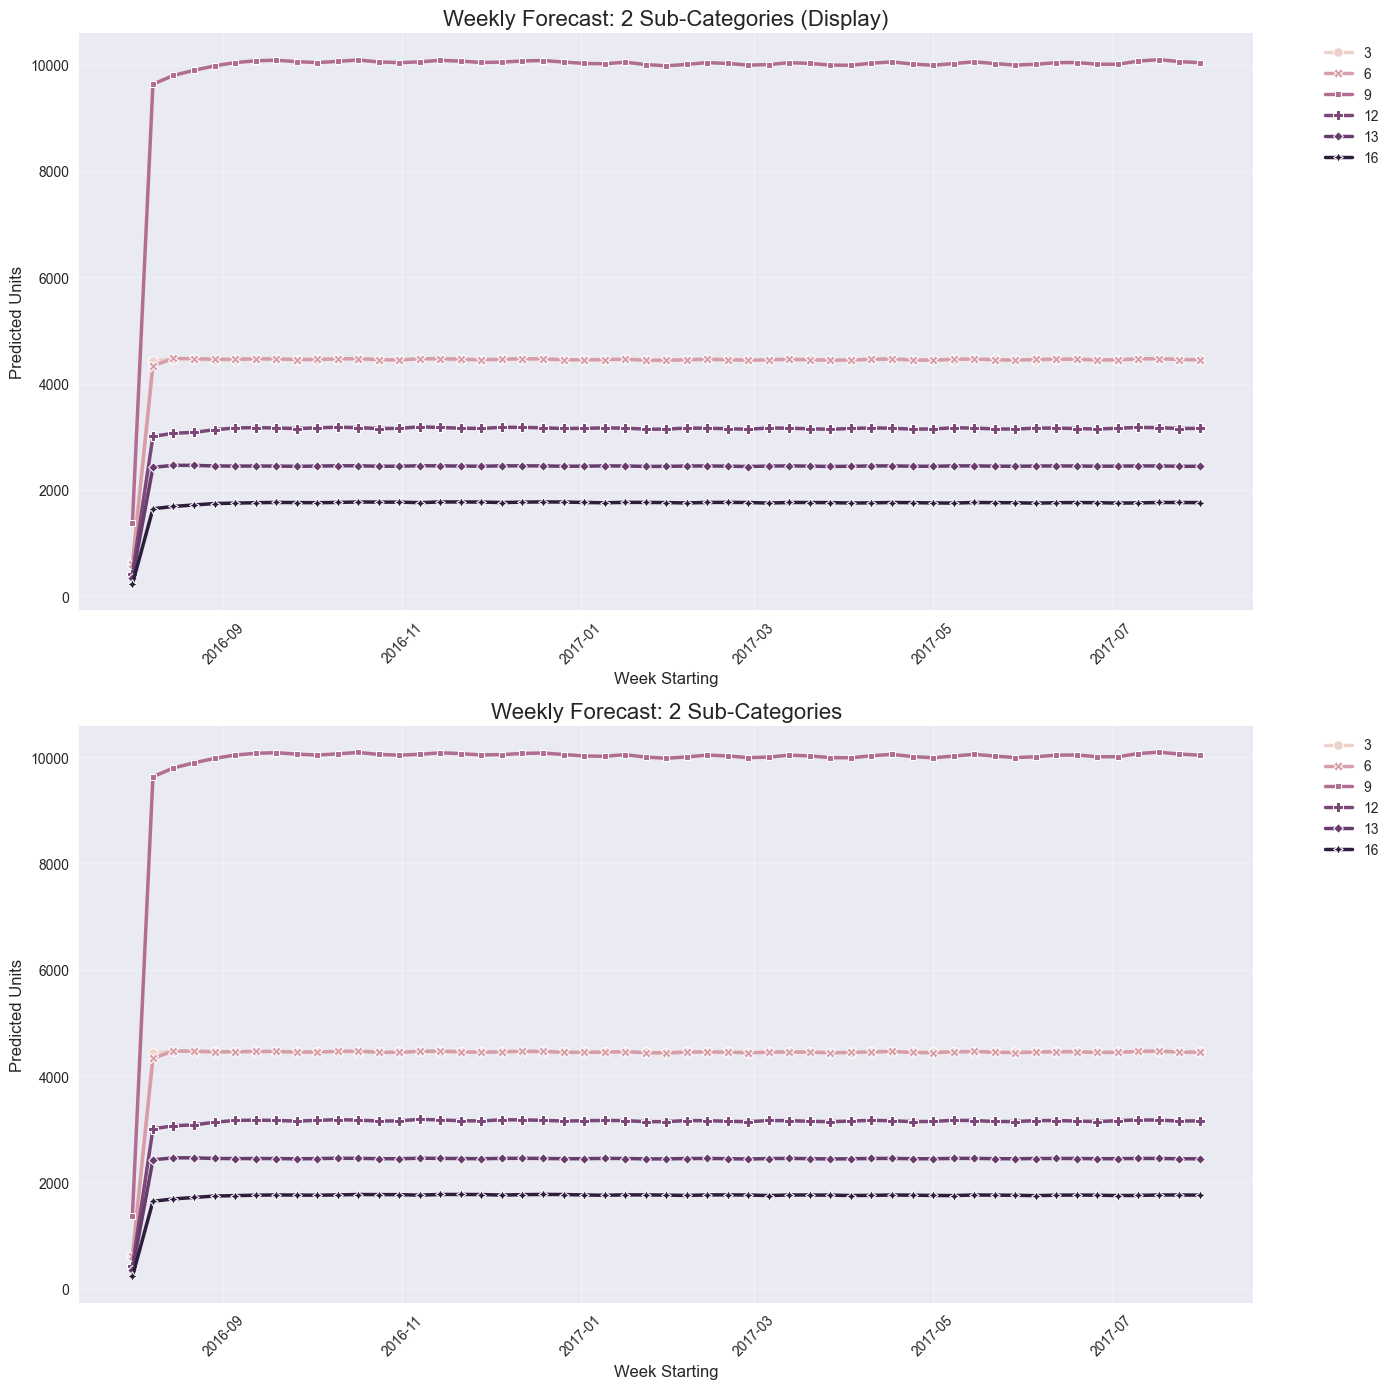

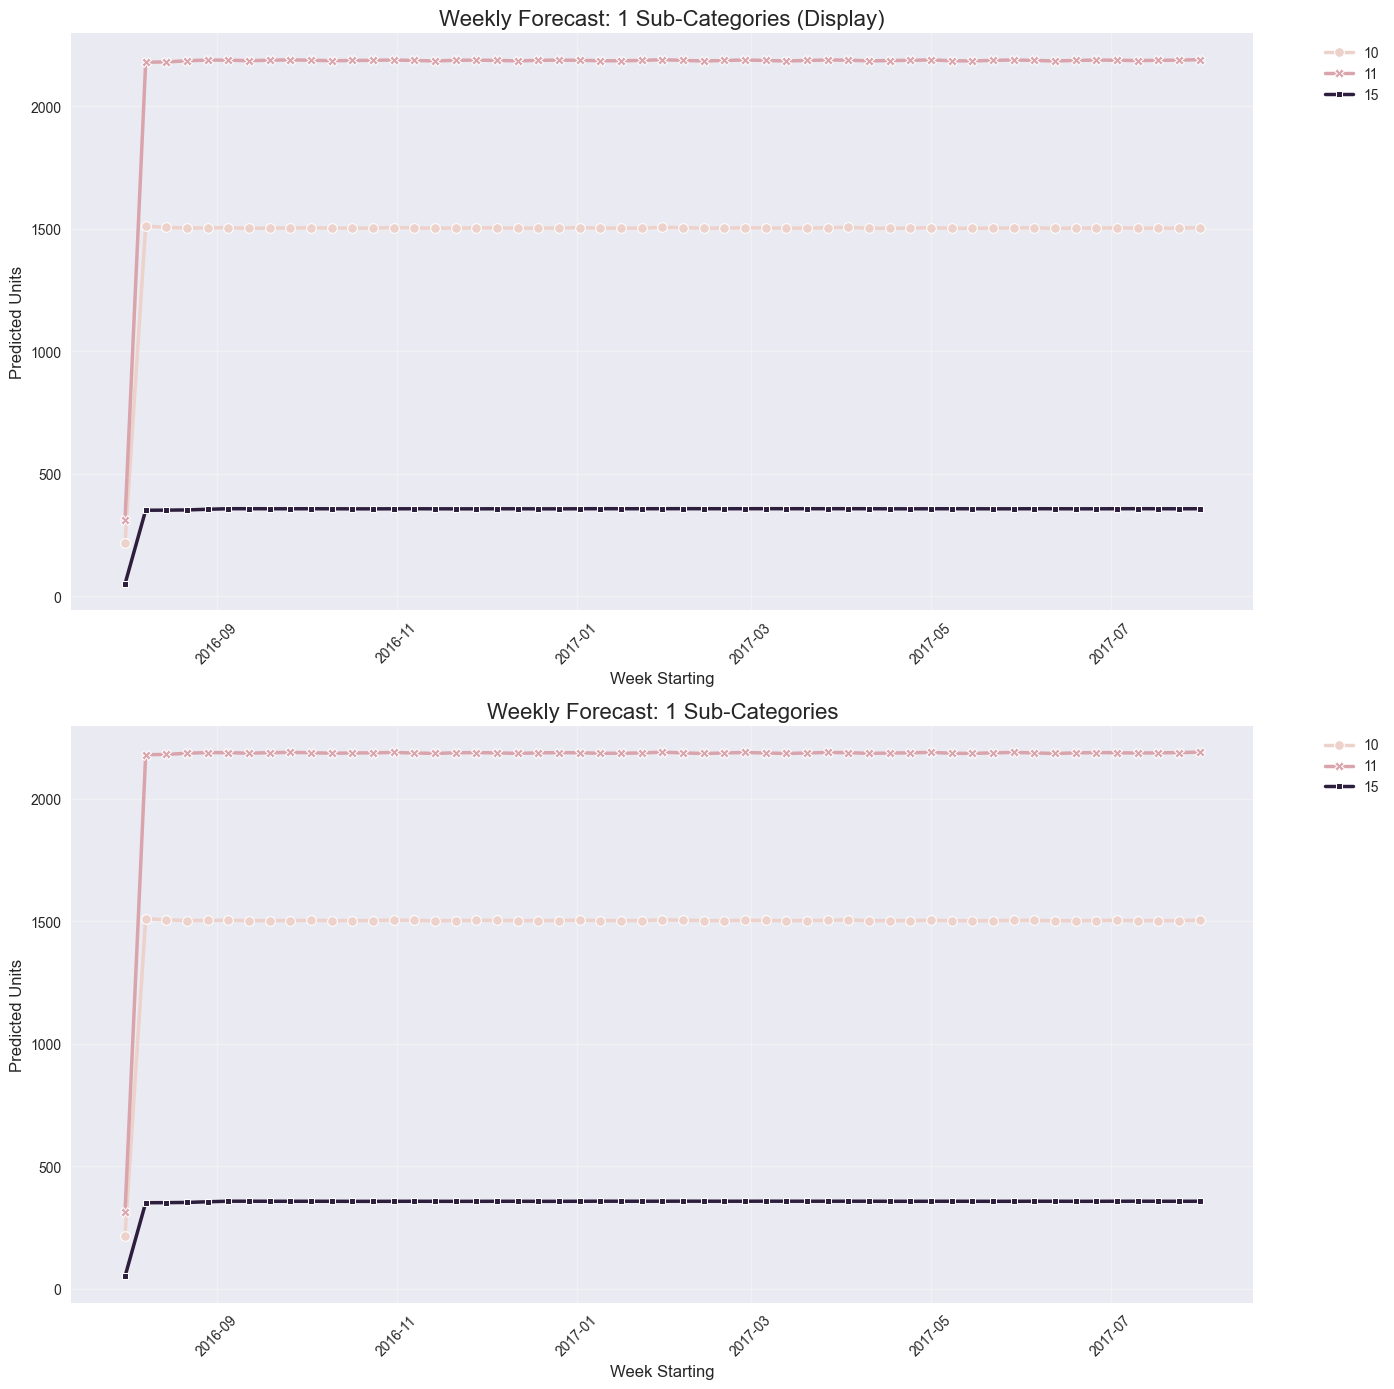

In [29]:
# 5. Specialized Plots for Key Features
# Product Category Breakdown
product_weekly = forecast_df.groupby([
    pd.Grouper(key='Date', freq='W-MON'),
    'Product_Category',
    'Sub_Category'
])['predicted'].sum().reset_index()

top_categories = product_weekly.groupby('Product_Category')['predicted'].sum().nlargest(3).index

# Set the style for all plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

for category in top_categories:
    cat_data = product_weekly[product_weekly['Product_Category'] == category]
    
    # Create figure with two subplots - one for display, one for saving
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))
    
    # Plot on first subplot (for display)
    sns.lineplot(
        data=cat_data,
        x='Date',
        y='predicted',
        hue='Sub_Category',
        style='Sub_Category',
        markers=True,
        dashes=False,
        linewidth=2.5,
        ax=ax1
    )
    ax1.set_title(f'Weekly Forecast: {category} Sub-Categories (Display)', fontsize=16)
    ax1.set_xlabel('Week Starting', fontsize=12)
    ax1.set_ylabel('Predicted Units', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot on second subplot (for saving)
    sns.lineplot(
        data=cat_data,
        x='Date',
        y='predicted',
        hue='Sub_Category',
        style='Sub_Category',
        markers=True,
        dashes=False,
        linewidth=2.5,
        ax=ax2
    )
    ax2.set_title(f'Weekly Forecast: {category} Sub-Categories', fontsize=16)
    ax2.set_xlabel('Week Starting', fontsize=12)
    ax2.set_ylabel('Predicted Units', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Create safe filename
    if isinstance(category, str):
        filename = f'weekly_forecast_{category.lower().replace(" ", "_")}_subcategories.png'
    else:
        filename = f'weekly_forecast_category_{category}_subcategories.png'
    
    
    # Display the figure (will show both subplots)
    plt.show()

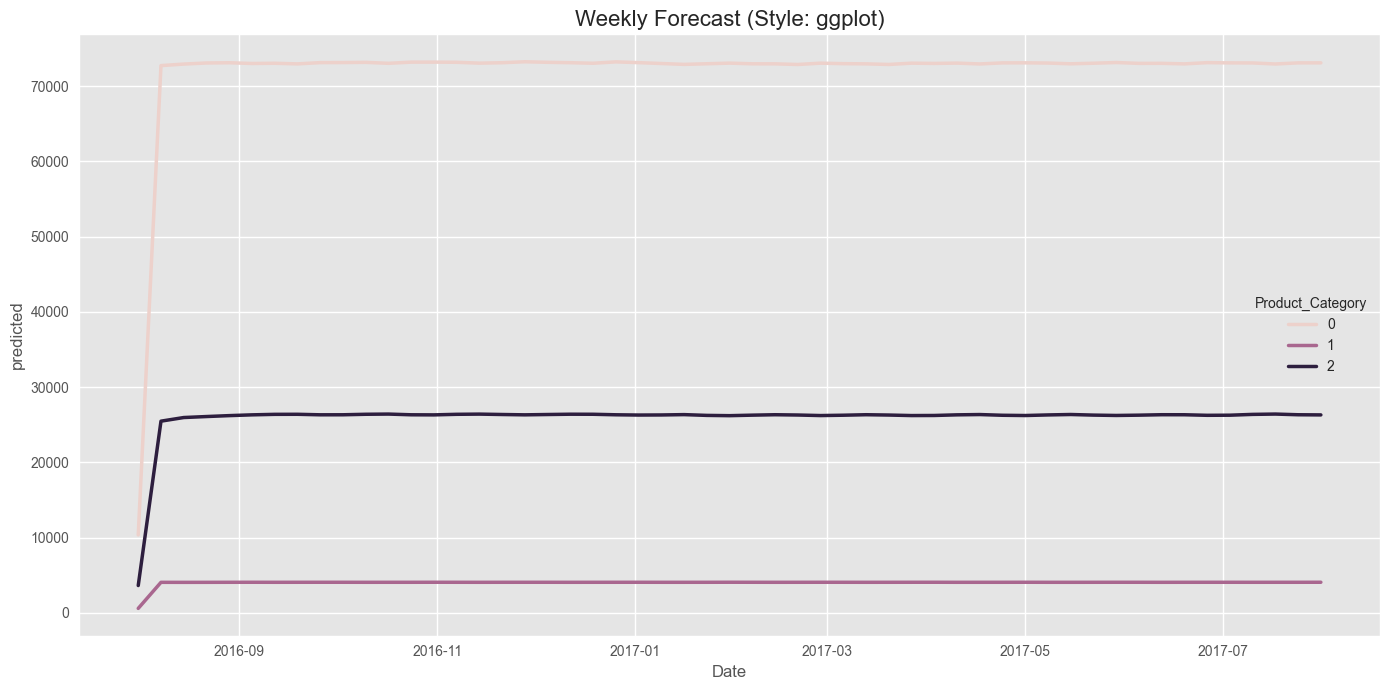

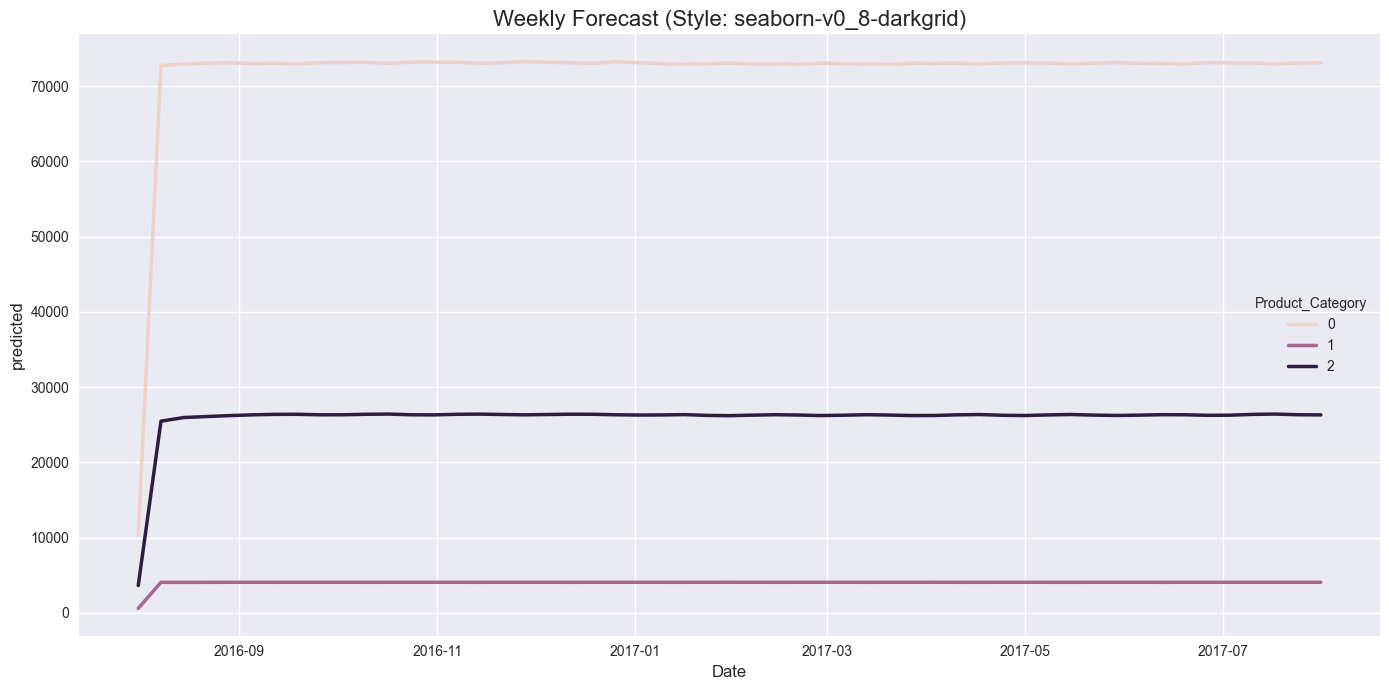

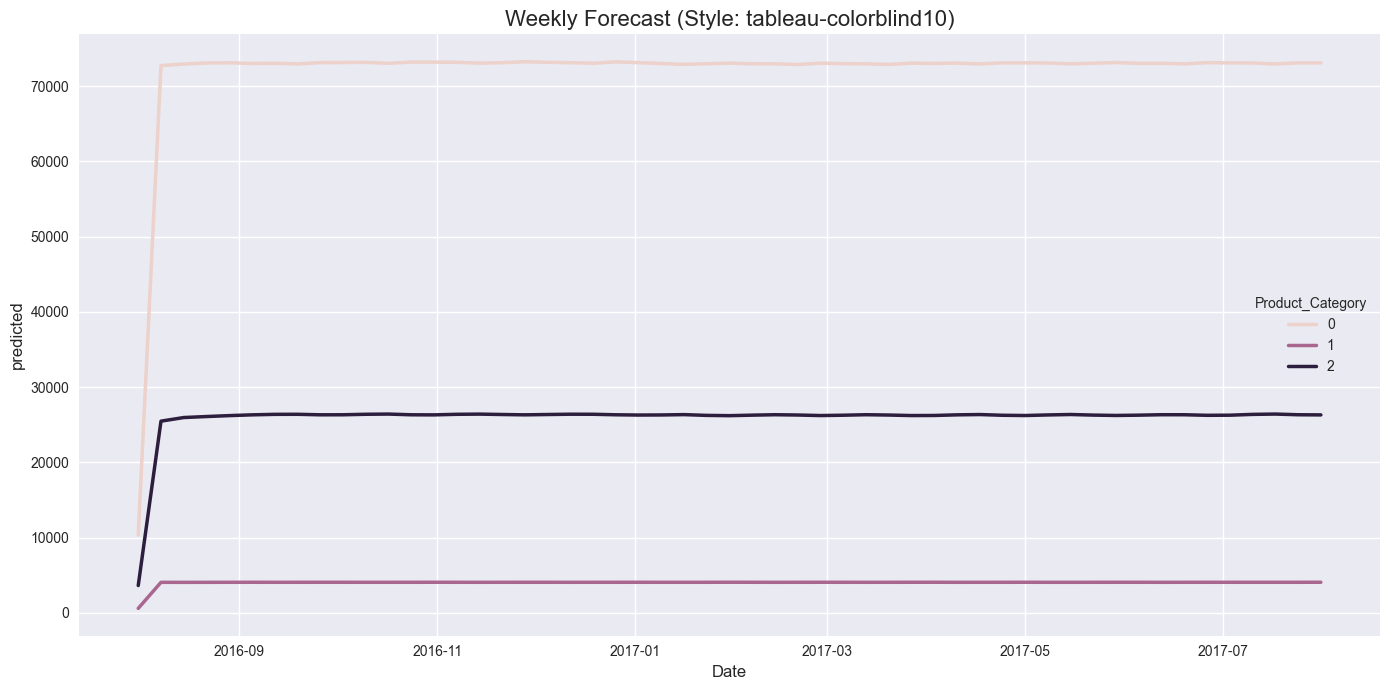

In [30]:
# 6. Alternative style examples
def plot_with_style(style_name):
    plt.style.use(style_name)
    plt.figure(figsize=(14, 7))
    sns.lineplot(
        data=weekly_data[weekly_data['Product_Category'].isin(
            weekly_data['Product_Category'].value_counts().index[:3])],
        x='Date',
        y='predicted',
        hue='Product_Category',
        linewidth=2.5
    )
    plt.title(f'Weekly Forecast (Style: {style_name})', fontsize=16)
    plt.tight_layout()
    plt.show()

# Try different styles
for style in ['ggplot', 'seaborn-v0_8-darkgrid', 'tableau-colorblind10']:
    plot_with_style(style)

In [2]:
import nbformat
from nbconvert import PythonExporter

def convert_ipynb_to_py(ipynb_file, py_file):
    with open(ipynb_file, 'r', encoding='utf-8') as f:
        notebook = nbformat.read(f, as_version=4)
    
    exporter = PythonExporter()
    python_code, _ = exporter.from_notebook_node(notebook)
    
    with open(py_file, 'w', encoding='utf-8') as f:
        f.write(python_code)

# Usage
convert_ipynb_to_py('sales_prediction.ipynb', 'analysis.py')